In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     |████████████████████████████████| 1.1 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.2 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 596 kB 65.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 59.5 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 4.8 MB/s  eta 0:00:01


In [3]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

170508288/170498071 [==============================] - 11s 0us/step


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [5]:
denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 32, 32, 3)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
Non-

In [6]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 3)        867       
 nspose)                                                         
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [7]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 31s 11ms/step - loss: 0.5931 - mse: 0.0185 - val_loss: 0.5829 - val_mse: 0.0134
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5723 - mse: 0.0098 - val_loss: 0.5755 - val_mse: 0.0106
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5674 - mse: 0.0079 - val_loss: 0.5723 - val_mse: 0.0094
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5652 - mse: 0.0071 - val_loss: 0.5712 - val_mse: 0.0090
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5639 - mse: 0.0066 - val_loss: 0.5680 - val_mse: 0.0076
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5631 - mse: 0.0063 - val_loss: 0.5669 - val_mse: 0.0073
Epoch 7/10
1563/1563 [==============================] - 16s 11ms/step - loss: 0.5625 - mse: 0.0061 - val_loss: 0.5658 - val_mse: 0.0068
Epoch 8/10
1563/1563 [==========================

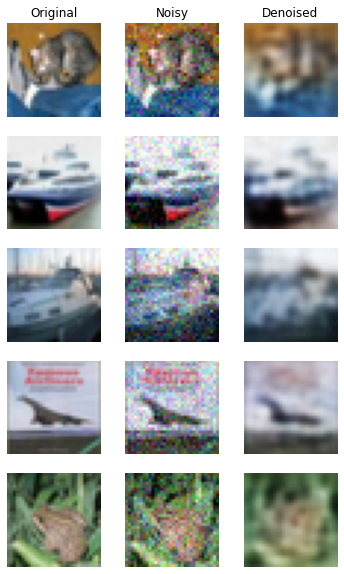

In [8]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()